In [2]:
import pandas as pd
import numpy as np
import scipy as sy
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from time import time

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_train = pd.read_csv('//tsclient/U/General/Stand/train.csv')

In [25]:
df_test = pd.read_csv('//tsclient/U/General/Stand/test.csv')

In [9]:
ID = df_train['ID']
Y = df_train['target']
log_Y = np.log(Y)
df_train.drop(['ID','target'],axis=1,inplace=True)

In [10]:
S = 1 # Stride length
L = 100
prd_all = df_train.columns
nrows_all = ((prd_all.size-100)//1)+1
n = prd_all.strides[0]

In [11]:
predictors_all = np.lib.stride_tricks.as_strided(prd_all,shape=(nrows_all,L),strides=(S*n,n))

In [12]:
## Growing large number of RF trees 
model_1 = RandomForestRegressor(n_jobs=-1,n_estimators=2000,random_state=10,max_depth=2)

In [13]:
df_fea_imp_all = pd.DataFrame(columns=['Feature_Name','Imp'])
feats_all={}
for pred in predictors_all:
    model_1.fit(df_train[pred],log_Y)
    pred_1_col_names = df_train[pred].columns
    for feature,importance in zip(pred_1_col_names,model_1.feature_importances_):
        feats_all[feature] = importance
    importances = pd.DataFrame.from_dict(feats_all, orient='index').reset_index().rename(columns={'index':'Feature_Name',0: 'Imp'})
    df_fea_imp_all = df_fea_imp_all.append(importances) 

Now that we have built a multiple random forest to assess the feature importance, lets aggregate across all the Feature_Importances to find the Average, Median,Max & Min feature importance 

In [18]:
df_fea_imp_sorted_all = df_fea_imp_all.groupby(['Feature_Name'])['Imp'].mean().sort_values(ascending=False).reset_index()
df_fea_imp_sorted_all.to_csv('//tsclient/U/General/Stand/fea_imp.csv',index=False)

In [19]:
df_fea_imp_sorted_all_med = df_fea_imp_all.groupby(['Feature_Name'])['Imp'].median().sort_values(ascending=False).reset_index()
df_fea_imp_sorted_all_med.to_csv('//tsclient/U/General/Stand/fea_imp_median.csv',index=False)

In [20]:
df_fea_imp_sorted_all_max = df_fea_imp_all.groupby(['Feature_Name'])['Imp'].max().sort_values(ascending=False).reset_index()
df_fea_imp_sorted_all_max.to_csv('//tsclient/U/General/Stand/fea_imp_max.csv',index=False)

In [21]:
df_fea_imp_sorted_all_min = df_fea_imp_all.groupby(['Feature_Name'])['Imp'].min().sort_values(ascending=False).reset_index()
df_fea_imp_sorted_all_min.to_csv('//tsclient/U/General/Stand/fea_imp_min.csv',index=False)

Let's use all the features whose average Feature Imp is > 0.005 and build a model

In [23]:
rf_fea_imp = df_fea_imp_sorted_all.Feature_Name[df_fea_imp_sorted_all.Imp > 0.005]

In [26]:
df_train_rf_sample = df_train.filter(items=rf_fea_imp)
df_test_rf_sample = df_test.filter(items=rf_fea_imp)

In [28]:
tr = MinMaxScaler()
df_train_sample_rf_tr = tr.fit_transform(df_train_rf_sample.values)
df_test_sample_rf_tr = tr.transform(df_test_rf_sample.values)

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from time import time

In [30]:
grid_param_grid = {"n_estimators": [200, 500,1000],
    "max_depth": [3, None],
    "max_features": [1, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [True, False],
    "criterion" :['mse','mae']}

In [31]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [32]:
model = RandomForestRegressor(random_state=10)
n_iter_search = 20
grid_search = RandomizedSearchCV(estimator=model,param_distributions=grid_param_grid,n_iter=n_iter_search,scoring='mean_squared_error')

In [33]:
X_train, X_val, y_train, y_val = train_test_split(df_train_rf_sample, log_Y, test_size = 0.2, random_state = 0)

In [34]:
start = time()

In [35]:
grid_search.fit(X_train,y_train)
print("GridSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(grid_search.cv_results_)

GridSearchCV took 3950.60 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -2.130 (std: 0.074)
Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 10, 'max_depth': None, 'criterion': 'mse', 'bootstrap': True}

Model with rank: 2
Mean validation score: -2.132 (std: 0.083)
Parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 5, 'max_depth': None, 'criterion': 'mae', 'bootstrap': False}

Model with rank: 3
Mean validation score: -2.149 (std: 0.079)
Parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 3, 'max_depth': None, 'criterion': 'mse', 'bootstrap': False}



In [36]:
y_pred_val = grid_search.predict(X_val)

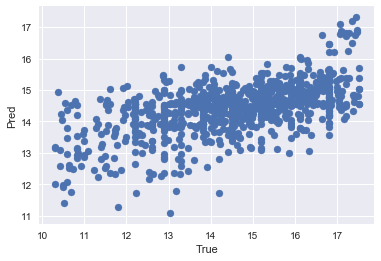

In [37]:
plt.scatter(y_val, y_pred_val)
plt.xlabel("True")
plt.ylabel("Pred")

In [38]:
log_ypred = grid_search.predict(df_test_sample_rf_tr)

In [39]:
ypred = np.exp(log_ypred)
ID = df_test['ID']
rf_sub = pd.DataFrame({'ID':ID,'target':ypred})

In [40]:
rf_sub.to_csv('//tsclient/U/General/Stand/submission__aug_05_0.1.csv',index=False)

If we submit the above file, we get a score of 1.82 (topper is @ 0.47), 
which isnt bad considering the minimum effort we had put in and the choice of algorithm.